In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
import napari
import pandas as pd
from skimage.measure import label as skimage_label, regionprops_table
from laptrack import LapTrack
from laptrack import datasets
from laptrack.data_conversion import convert_split_merge_df_to_napari_graph
import os
from patchify import patchify  
import random
from scipy import ndimage
import datasets
from skimage.transform import resize
from skimage import exposure
from datasets import Dataset
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor
import torch
import cv2
from skimage import measure
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import os
from tqdm import tqdm
import time
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from datasets import Dataset as HFDataset
import random
from transformers import SamConfig, SamProcessor, SamModel


## Load the models

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the pretrained model
pretrained_model = SamModel.from_pretrained("facebook/sam-vit-base")
pretrained_model.to(device)
pretrained_model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [5]:
# Load the fine-tuned model
finetuned_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

finetuned_model = SamModel(config=finetuned_config)
checkpoint_path = os.path.join(os.getcwd(), "finetuned_model_checkpoint.pth")
finetuned_model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
finetuned_model.to(device)
finetuned_model.eval()


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Detailed Calculation for one slice

### Probability map from fine-tuned SAM 

In [8]:
m = 3  # Which image
n = 25  # Which slice

# Define the base directory (assuming you're inside 'nuclei_seg_mouse' folder)
base_dir = os.getcwd()

# Construct robust relative file paths
test_images_path = os.path.join(base_dir, "test_data_7", "intensity", f"intensity-{m:02d}.tif")
test_labels_path = os.path.join(base_dir, "test_data_7", "label", f"intensity-{m:02d}_3d_corr.tif")

# Read the images and labels
test_images = tifffile.imread(test_images_path)
test_labels = tifffile.imread(test_labels_path)

# Downsample test images
downsampled_test_images = np.zeros((test_images.shape[0], 256, 256))
for i in range(test_images.shape[0]):
    downsampled_test_images[i] = resize(test_images[i], (256, 256), anti_aliasing=True)
test_images = downsampled_test_images

# Downsample test masks
downsampled_test_labels = np.zeros((test_labels.shape[0], 256, 256))
for i in range(test_labels.shape[0]):
    downsampled_test_labels[i] = resize(test_labels[i], (256, 256), anti_aliasing=True)
test_labels = downsampled_test_labels

In [9]:
def generate_grid_points(array_size=256, grid_size=10):
    """
    Generates a grid of 2D spatial points for prompt encoding.

    Parameters:
    - array_size (int): The size of the image (height/width).
    - grid_size (int): The number of grid points along each axis.

    Returns:
    - torch.Tensor: A tensor of shape (1, 1, grid_size * grid_size, 2)
      representing the input points for the model.
    """

    # Generate evenly spaced grid points
    x = np.linspace(0, array_size - 1, grid_size)
    y = np.linspace(0, array_size - 1, grid_size)

    # Create a grid of coordinates
    xv, yv = np.meshgrid(x, y)

    # Convert to integer lists
    grid_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]

    # Reshape to match the expected input tensor shape: (batch_size, point_batch_size, num_points_per_image, 2)
    input_points_tensor = torch.tensor(grid_points).view(1, 1, grid_size * grid_size, 2)

    return input_points_tensor

# Set parameters
ARRAY_SIZE = 256
GRID_SIZE = 10

# Generate input points
input_points = generate_grid_points(ARRAY_SIZE, GRID_SIZE)

# Print shape to verify correctness
print(f"Generated input_points shape: {input_points.shape}")

Generated input_points shape: torch.Size([1, 1, 100, 2])


In [10]:
# Function to convert each slice to an RGB image
def convert_to_rgb(image_slice):
    image_rgb = np.stack([image_slice]*3, axis=-1)  # Replicate the grayscale image across 3 channels
    return Image.fromarray((image_rgb * 255).astype(np.uint8))  # Ensure the array is in the right format for an image

# Convert each slice of the downsampled test_images to RGB
converted_test_images = [convert_to_rgb(downsampled_test_images[i]) for i in range(downsampled_test_images.shape[0])]

# Verify the conversion by checking one of the images
print(type(converted_test_images[0]))  # Should be <class 'PIL.Image.Image'>
print(converted_test_images[0].mode)   # Should be 'RGB'
print(converted_test_images[0].size)   # Should be (256, 256)

converted_test_images = converted_test_images[n]

<class 'PIL.Image.Image'>
RGB
(256, 256)


In [11]:
# Use grid points as prompts
inputs = processor(converted_test_images, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

In [12]:
# Forward pass for pretrained model
with torch.no_grad():
    pretrained_outputs = pretrained_model(**inputs, multimask_output=False)

# Forward pass for fine-tuned model
with torch.no_grad():
    finetuned_outputs = finetuned_model(**inputs, multimask_output=False)

# Apply sigmoid activation to get probability maps
finetuned_prob = torch.sigmoid(finetuned_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
pretrained_prob = torch.sigmoid(pretrained_outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()

# Convert soft masks to hard masks
finetuned_seg = (finetuned_prob > 0.8).astype(np.uint8)
pretrained_seg = (pretrained_prob > 0.8).astype(np.uint8)

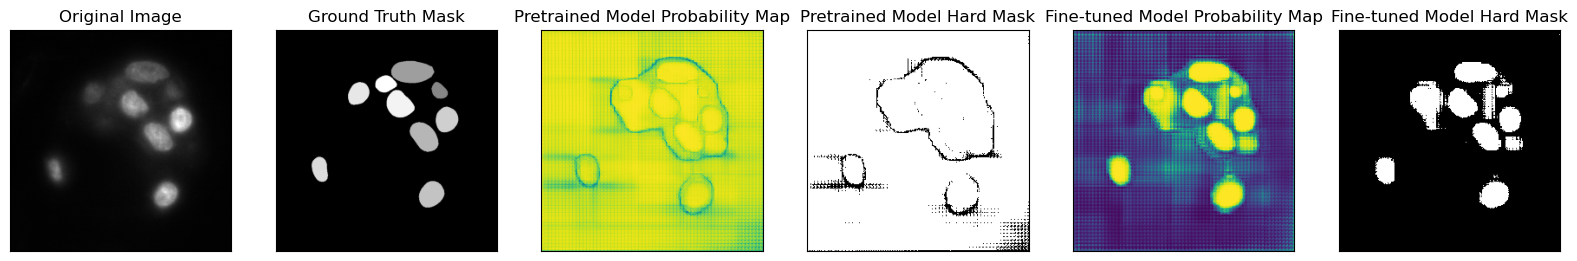

In [13]:
# Plot comparison
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(np.array(test_images[n]), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(np.array(test_labels[n]), cmap='gray')
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pretrained_prob)
axes[2].set_title("Pretrained Model Probability Map")

axes[3].imshow(pretrained_seg, cmap='gray')
axes[3].set_title("Pretrained Model Hard Mask")

axes[4].imshow(finetuned_prob)
axes[4].set_title("Fine-tuned Model Probability Map")

axes[5].imshow(finetuned_seg, cmap='gray')
axes[5].set_title("Fine-tuned Model Hard Mask")

# Remove axis labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Show the plot
plt.show()


### Watershed segmentation 

In [15]:
# Extract the first image from finetuned_prob
img = finetuned_prob

# Ensure grayscale conversion only if needed
if len(img.shape) == 3 and img.shape[2] == 3:  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:  
    gray = img  # Already grayscale

# Normalize and convert to 8-bit if necessary
if gray.dtype != np.uint8:
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



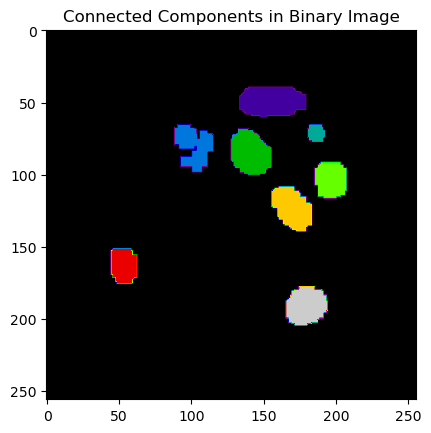

In [16]:
# Noise Removal using Morphological Operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Create binary mask for high-intensity regions
binary_mask = ((gray > 230) * 255).astype(np.uint8)

# Apply morphological opening to remove small noise
seeds = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Label connected components in the binary image
labeled_seeds = measure.label((seeds > 0).astype(int), connectivity=2)

# Display the labeled connected components
plt.imshow(labeled_seeds, cmap='nipy_spectral')
plt.title("Connected Components in Binary Image")
plt.show()

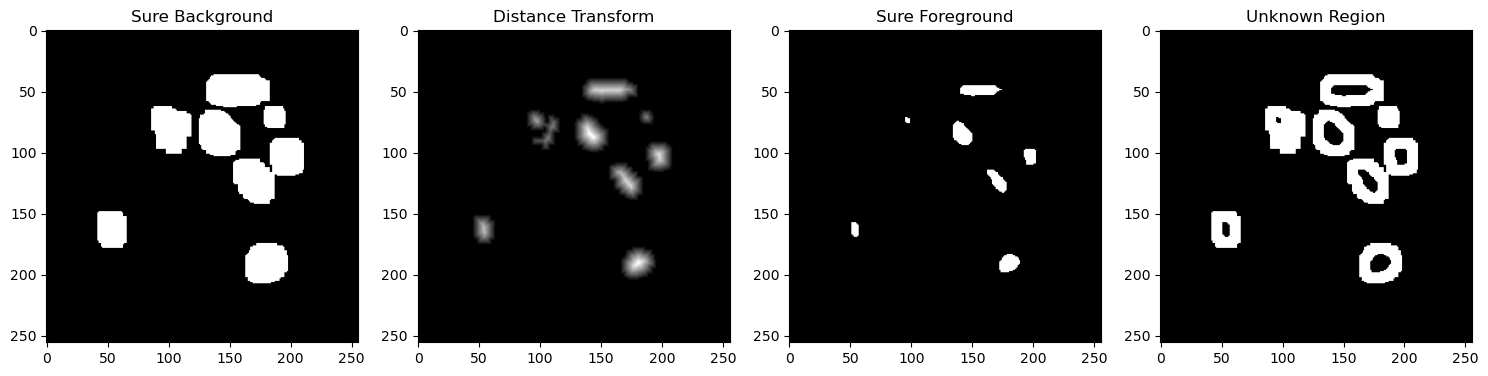

In [17]:
# Create subplots with 1 row and 4 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Step 1: Sure Background Area (Dilating the Seeds)
sure_bg = cv2.dilate(seeds, kernel, iterations=3)
axes[0].imshow(sure_bg, cmap='gray')
axes[0].set_title('Sure Background')

# Step 2: Compute Distance Transform
dist = cv2.distanceTransform(seeds, cv2.DIST_L2, 5)
axes[1].imshow(dist, cmap='gray')
axes[1].set_title('Distance Transform')

# Step 3: Identify Sure Foreground Area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
axes[2].imshow(sure_fg, cmap='gray')
axes[2].set_title('Sure Foreground')

# Step 4: Compute Unknown Region (Sure Background - Sure Foreground)
unknown = cv2.subtract(sure_bg, sure_fg)
axes[3].imshow(unknown, cmap='gray')
axes[3].set_title('Unknown Region')

# Improve layout and display the plots
plt.tight_layout()
plt.show()


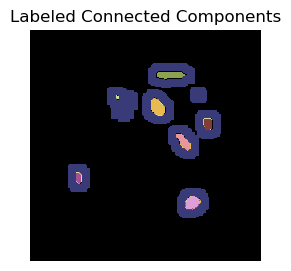

In [18]:
# Step 1: Marker Labelling - Identify Connected Components
# Finds all connected components (regions of connected pixels) in the binary image "sure_fg"
num_components, markers = cv2.connectedComponents(sure_fg)

# "num_components" stores the number of connected components found.
# "markers" is an array where each connected component is labeled with a unique integer.
# The background is typically labeled as 0.

# Step 2: Adjust Labels
markers += 1  # Shift labels so background becomes 1 instead of 0
markers[unknown == 255] = 0  # Mark unknown region as 0

# Step 3: Define Custom Colormap
num_labels = np.max(markers) + 1  # Get total number of labels
colors = plt.cm.tab20b(np.linspace(0, 1, num_labels))  # Get distinct colors
colors[1] = [0, 0, 0, 1]  # Set label 1 (background) to black (RGBA format)

custom_cmap = mcolors.ListedColormap(colors)

# Step 4: Plot the Labeled Image
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(markers, cmap=custom_cmap)
ax.set_title("Labeled Connected Components")
ax.axis("off")
plt.show()


Each color represents a different labeled region (connected component) in the image.
- The background (label 1) is typically one color - black.
- The unknown region (label 0) is a different color.
- Different objects (segmented regions) have different colors, helping visualize distinct regions.

In [20]:
# Ensure the image is in the correct format for watershed
if img.dtype != np.uint8 or len(img.shape) != 3 or img.shape[2] != 3:
    img = cv2.cvtColor(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLOR_GRAY2BGR)
markers = markers.astype(np.int32)

In [21]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

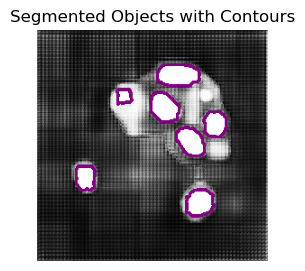

In [22]:
# Get Unique Labels from the Watershed Output
labels = np.unique(markers)

# Extract Contours for Each Labeled Object
coins = []
for label in labels[2:]:  # Skip background (label 1) and boundary (label -1)
    
    # Create a binary mask where only the target label is foreground
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Extract contours from the binary mask
    contours, _ = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:  # Ensure at least one contour is found
        coins.append(contours[0])

# Draw the Contours on the Original Image
img_with_contours = img.copy()
cv2.drawContours(img_with_contours, coins, -1, color=(128, 0, 128), thickness=2)

# Display the Result
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img_with_contours)
ax.set_title("Segmented Objects with Contours")
ax.axis("off")
plt.show()


In [23]:
# watershed segmentation
watershed_seg = markers

# Convert all -1 and 1 (background) to 0 (black)
watershed_seg[(watershed_seg == -1) | (watershed_seg == 1)] = 0

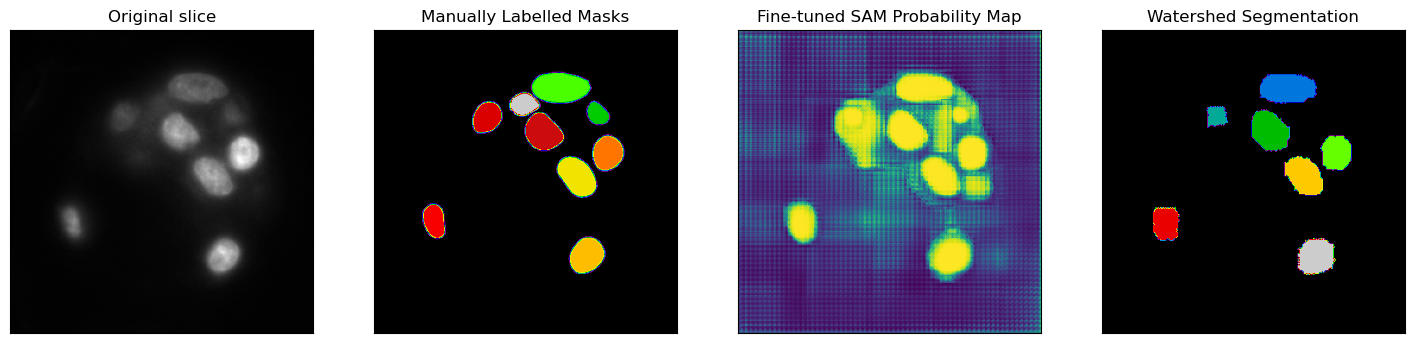

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_images[n]),cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Original slice")

axes[1].imshow(np.array(test_labels[n]), cmap='nipy_spectral')  
axes[1].set_title("Manually Labelled Masks")

# Plot the second image on the right
axes[2].imshow(finetuned_prob)  
axes[2].set_title("Fine-tuned SAM Probability Map")

# Plot the second image on the right
axes[3].imshow(watershed_seg, cmap='nipy_spectral')  
axes[3].set_title("Watershed Segmentation")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


# Display the images side by side
plt.show()

## Calculation for all 7_test_data

In [26]:
# Function to convert each slice to an RGB image
def convert_to_rgb(image_slice):
    image_rgb = np.stack([image_slice]*3, axis=-1)  # Replicate the grayscale image across 3 channels
    return Image.fromarray((image_rgb * 255).astype(np.uint8))  # Ensure the array is in the right format for an image

In [27]:
# Define the size of your array
array_size = 256
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

# Reshape input_points tensor
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [28]:
def perform_watershed_segmentation(test_prob):
    img = test_prob
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Normalize and convert to 8-bit if necessary
    if gray.dtype != np.uint8:
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    seeds = cv2.morphologyEx(((gray > 230) * 255).astype('uint8'), cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(seeds, kernel, iterations=3)
    dist = cv2.distanceTransform(seeds, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    if img.dtype != np.uint8 or len(img.shape) != 3 or img.shape[2] != 3:
        img = cv2.cvtColor(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    markers = markers.astype(np.int32)

    markers = cv2.watershed(img, markers)
    watershed_seg = markers
    watershed_seg[(watershed_seg == -1) | (watershed_seg == 1)] = 0

    return watershed_seg


In [29]:
def finetuned_watershed_process_slice(m, n, model, processor, device):
    base_dir = os.getcwd()  # Get current working directory 
    test_images_path = os.path.join(base_dir, "test_data_7", "intensity", f"intensity-{m:02d}.tif")
    
    # Read the images
    test_images = tifffile.imread(test_images_path)
    
    # Downsample test_images to 256x256
    downsampled_test_images = np.zeros((test_images.shape[0], 256, 256))
    for i in range(test_images.shape[0]):
        downsampled_test_images[i] = resize(test_images[i], (256, 256), anti_aliasing=True)
    
    # Convert a slice of the downsampled test_images to RGB
    converted_test_images = [convert_to_rgb(downsampled_test_images[i]) for i in range(downsampled_test_images.shape[0])]
    converted_test_images = converted_test_images[n]

    # Process the inputs
    inputs = processor(converted_test_images, input_points=input_points, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Set model to evaluation mode and get outputs
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # Apply sigmoid to get probabilities
    test_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    test_prob = test_prob.detach().cpu().numpy().squeeze()

    # Perform watershed segmentation
    watershed_seg = perform_watershed_segmentation(test_prob)
    
    # Upsample the segmentation result back to the original image size
    upsampled_segmentation = resize(watershed_seg, (test_images.shape[1], test_images.shape[2]), order=0, preserve_range=True, anti_aliasing=False)
    
    return upsampled_segmentation

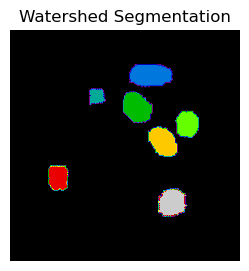

In [77]:
# Example usage
m = 3
n = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
watershed_seg = finetuned_watershed_process_slice(m, n, finetuned_model, processor, device)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(watershed_seg, cmap='nipy_spectral')
ax.set_title('Watershed Segmentation')
ax.axis('off')
plt.show()

In [31]:
# Dictionary to store results
masks_finetunedSAM_watershed_test_7_all = {}

# Get the current working directory (assumed to be nuclei_seg_mouse)
base_dir = os.getcwd()

# Iterate over images from intensity-01.tif to intensity-07.tif
for i in tqdm(range(1, 8), desc="Processing Images", unit="image"):
    masks_per_slice = []
    
    # Construct the robust relative file path
    file_path = os.path.join(base_dir, "test_data_7", "intensity", f"intensity-{i:02d}.tif")
    
    # Load the 3D image using tifffile
    image_3d = tifffile.imread(file_path)
    
    # Process each slice in the 3D image
    for j in range(image_3d.shape[0]):
        masks = finetuned_watershed_process_slice(i, j, finetuned_model, processor, device)
        masks_per_slice.append(masks)
    
    # Store the processed masks in the dictionary
    masks_finetunedSAM_watershed_test_7_all[i] = masks_per_slice


Processing Images: 100%|██████████████████████| 7/7 [15:15<00:00, 130.79s/image]


In [32]:
# Save the result 
output_file = os.path.join(os.getcwd(), "masks_finetunedSAM_watershed_test_7_all.pkl")

# Save the dictionary as a .pkl file
with open(output_file, "wb") as f:
    pickle.dump(masks_finetunedSAM_watershed_test_7_all, f)
print(f"Saved masks_finetunedSAM_watershed_test_7_all successfully")

Saved masks_finetunedSAM_watershed_test_7_all successfully


## Comparison 

In [34]:
# Get the current working directory
base_dir = os.getcwd()

# Construct robust relative file paths
image_3d_path = os.path.join(base_dir, "test_data_7", "intensity", "intensity-01.tif")
label_3d_path = os.path.join(base_dir, "test_data_7", "label", "intensity-01_3d_corr.tif")

# Load the 3D images using tifffile
image_3d = tifffile.imread(image_3d_path)
label_3d = tifffile.imread(label_3d_path)

masks_finetunedSAM = masks_finetunedSAM_watershed_test_7_all[1]


In [35]:
# Load the result of pretrained SAM 

pkl_file = os.path.join(os.getcwd(), "masks_PretrainedSAM_test_7_all.pkl")

# Load the dictionary from the .pkl file
with open(pkl_file, "rb") as file:
    masks_PretrainedSAM_test_7_all = pickle.load(file)

print("Loaded masks_PretrainedSAM_test_7_all successfully!")

Loaded masks_PretrainedSAM_test_7_all successfully!


In [36]:
# Extract segmentation masks for image 1
masks_PretrainedSAM = masks_PretrainedSAM_test_7_all[1]

# Initialize a 3D mask array (same size as the intensity image)
masks_pretrained_3d = np.zeros_like(image_3d, dtype=np.uint8)  # Store the segmented masks for each slice

# Loop through each 2D slice in the 3D intensity image
for i in range(image_3d.shape[0]):
    slice_2d = image_3d[i, :, :]  # Extract the current slice
    masks = masks_PretrainedSAM[i]  # Get segmentation masks for this slice

    # Create a blank 2D mask (same shape as the slice)
    combined_mask = np.zeros_like(slice_2d, dtype=np.uint8)

    # Process each mask within the slice
    for j, mask in enumerate(masks):
        # Assign unique label values to each segmented region in the mask
        combined_mask[mask['segmentation']] = j + 1  # Labels start from 1

    # Store the processed 2D mask into the 3D mask array
    masks_pretrained_3d[i, :, :] = combined_mask

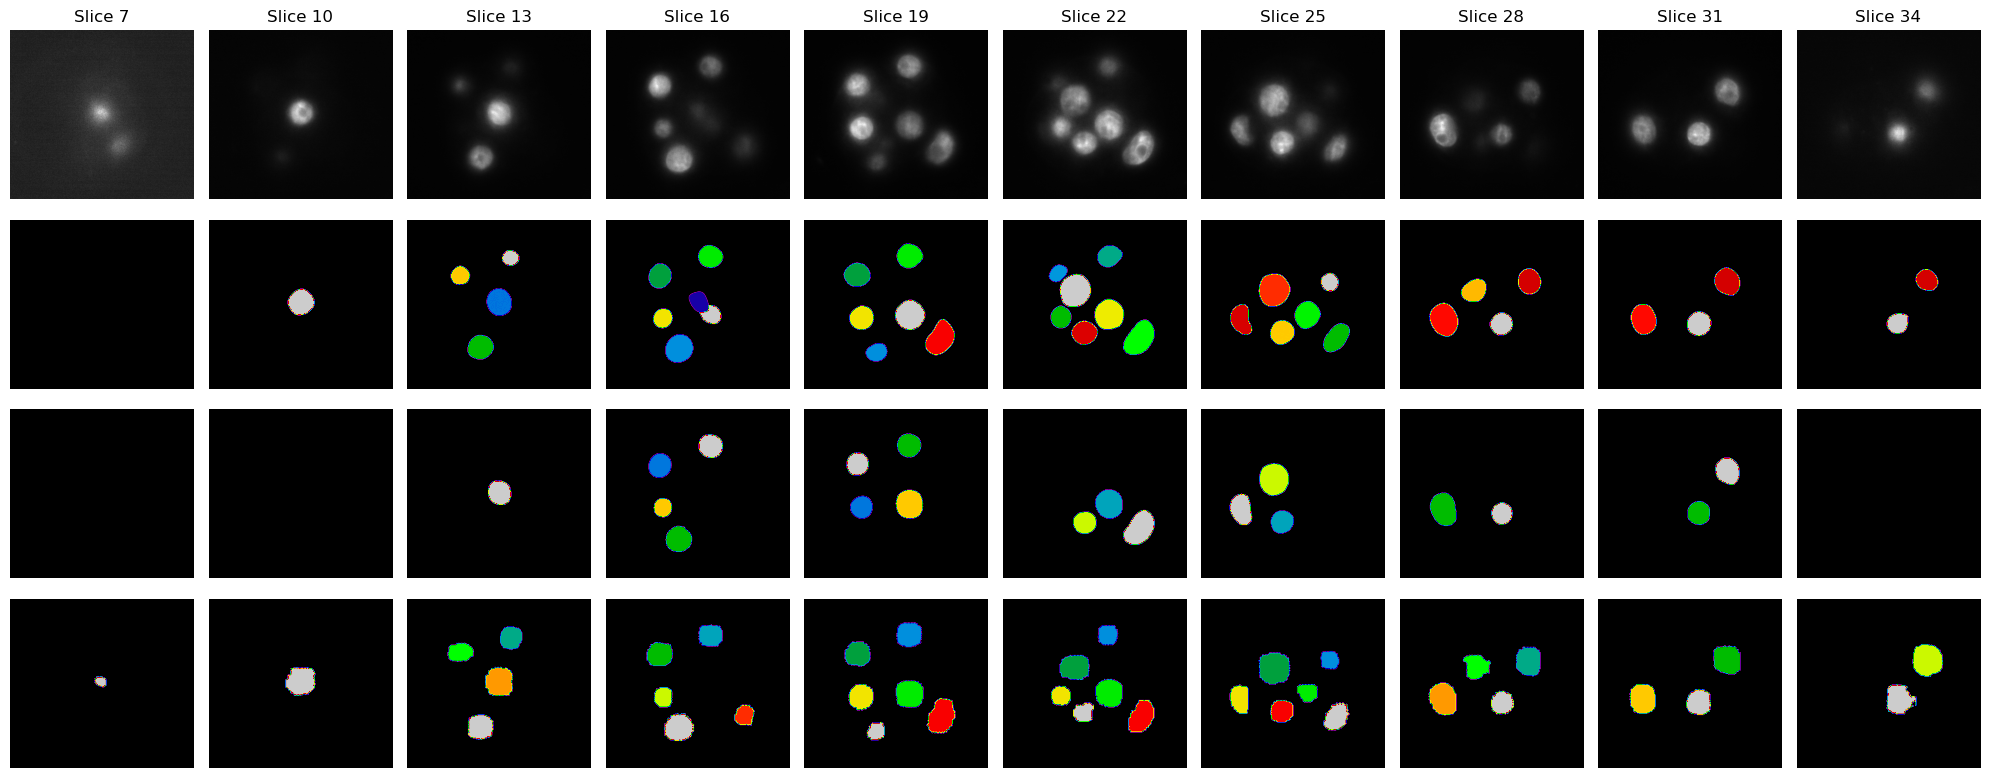

In [37]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))

for i in range(10):
        # Plot the ith slice of image_3d
        axes[0, i].imshow(image_3d[3*i+7], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Slice {3*i+7}')

        # Plot the ith slice of label_3d
        axes[1, i].imshow(label_3d[3*i+7], cmap='nipy_spectral')
        axes[1, i].axis('off')

        # Plot the ith slice of masks_3d
        axes[2, i].imshow(masks_pretrained_3d[3*i+7], cmap='nipy_spectral')
        axes[2, i].axis('off')

        # Plot the ith slice of masks_per_slice_finetuned
        axes[3, i].imshow(masks_finetunedSAM[3*i+7], cmap='nipy_spectral')
        axes[3, i].axis('off')

       


plt.tight_layout()
plt.show()



Row 1: Original slices;   
Row 2: Manually Labelled Masks;   
Row 3: Default SAM;   
Row 4: Fine-tuned SAM, watershed segmentation. 